In [65]:
import pandas as pd

df = pd.read_csv("/content/All_epochs_combined.csv")
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['trait_numeric'] = le.fit_transform(df['trait_anx_level'])


df = df.drop('Tree number', axis=1)
df= df.drop('trait_anx_level',axis=1)
# You manually define behavioral columns
behavior_columns = ['Time elapsed', 'Reaction time', 'Reward', 'Cumulative reward per tree','Total cumulative reward']

# The label column
label_column = 'Decision'


# Automatically get EEG columns = all columns except behavioral + label
eeg_columns = [col for col in df.columns if col not in behavior_columns + [label_column]]


In [66]:
non_numeric_cols = df[eeg_columns].select_dtypes(exclude=["number"]).columns
print("Non-numeric EEG columns:", list(non_numeric_cols))


Non-numeric EEG columns: []


In [67]:
print(df.dtypes)



Time elapsed                  float64
Decision                       object
Reaction time                 float64
Reward                          int64
Cumulative reward per tree      int64
                               ...   
P1_mean                       float64
P1_peak                       float64
P300_mean                     float64
P300_peak                     float64
trait_numeric                   int64
Length: 131, dtype: object


In [68]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert EEG and Behavioral Data to tensors
eeg_data = torch.tensor(df[eeg_columns].values, dtype=torch.float32)
behavior_data = torch.tensor(df[behavior_columns].values, dtype=torch.float32)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Decision'] = le.fit_transform(df['Decision'])  # overwrite or use a new column if you prefer

labels = torch.tensor(df['Decision'].values, dtype=torch.long)


In [69]:
from sklearn.model_selection import train_test_split

# Convert tensors to numpy for splitting
eeg_np = eeg_data.numpy()
behavior_np = behavior_data.numpy()
labels_np = labels.numpy()

# Split
eeg_train, eeg_test, behavior_train, behavior_test, labels_train, labels_test = train_test_split(
    eeg_np, behavior_np, labels_np, test_size=0.2, random_state=42, stratify=labels_np
)

# Convert back to tensors
eeg_train = torch.tensor(eeg_train, dtype=torch.float32)
eeg_test = torch.tensor(eeg_test, dtype=torch.float32)

behavior_train = torch.tensor(behavior_train, dtype=torch.float32)
behavior_test = torch.tensor(behavior_test, dtype=torch.float32)

labels_train = torch.tensor(labels_train, dtype=torch.long)
labels_test = torch.tensor(labels_test, dtype=torch.long)


In [70]:
train_dataset = TensorDataset(eeg_train, behavior_train, labels_train)
test_dataset = TensorDataset(eeg_test, behavior_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# ===== 1. Data Preparation (assuming you already have these) =====

# Convert to NumPy for splitting
eeg_np = eeg_data.numpy()
behavior_np = behavior_data.numpy()
labels_np = labels.numpy()

# Split into train and test
eeg_train, eeg_test, behavior_train, behavior_test, labels_train, labels_test = train_test_split(
    eeg_np, behavior_np, labels_np, test_size=0.2, random_state=42, stratify=labels_np
)

# Convert back to tensors
eeg_train = torch.tensor(eeg_train, dtype=torch.float32)
eeg_test = torch.tensor(eeg_test, dtype=torch.float32)

behavior_train = torch.tensor(behavior_train, dtype=torch.float32)
behavior_test = torch.tensor(behavior_test, dtype=torch.float32)

labels_train = torch.tensor(labels_train, dtype=torch.long)
labels_test = torch.tensor(labels_test, dtype=torch.long)

# DataLoaders
train_dataset = TensorDataset(eeg_train, behavior_train, labels_train)
test_dataset = TensorDataset(eeg_test, behavior_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ===== 2. Define Multi-Branch Model =====

eeg_dim = len(eeg_columns)
behavior_dim = len(behavior_columns)

class MultiBranchEEGBehaviorModel(nn.Module):
    def __init__(self, eeg_dim, behavior_dim):
        super().__init__()

        self.eeg_branch = nn.Sequential(
            nn.Linear(eeg_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.behavior_branch = nn.Sequential(
            nn.Linear(behavior_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32 + 16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # 2 classes: stay/leave
        )

    def forward(self, eeg_input, behavior_input):
        eeg_out = self.eeg_branch(eeg_input)
        behavior_out = self.behavior_branch(behavior_input)
        combined = torch.cat((eeg_out, behavior_out), dim=1)
        return self.classifier(combined)

# ===== 3. Train the Model =====

model = MultiBranchEEGBehaviorModel(eeg_dim, behavior_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for eeg_batch, behavior_batch, label_batch in train_loader:
        optimizer.zero_grad()
        output = model(eeg_batch, behavior_batch)
        loss = criterion(output, label_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == label_batch).sum().item()
        total += label_batch.size(0)

    accuracy = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")

# ===== 4. Inference on Test Set =====

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for eeg_batch, behavior_batch, label_batch in test_loader:
        output = model(eeg_batch, behavior_batch)
        predicted = torch.argmax(output, dim=1)
        all_preds.append(predicted)
        all_labels.append(label_batch)

# Combine predictions and labels
y_pred = torch.cat(all_preds)
y_true = torch.cat(all_labels)

# Print class distribution
print(f"\nPredicted class distribution: {torch.bincount(y_pred)}")


Epoch 1/10 | Loss: 462.6126 | Accuracy: 77.08%
Epoch 2/10 | Loss: 98.9325 | Accuracy: 82.75%
Epoch 3/10 | Loss: 67.9421 | Accuracy: 85.70%
Epoch 4/10 | Loss: 70.3339 | Accuracy: 85.97%
Epoch 5/10 | Loss: 50.0055 | Accuracy: 89.18%
Epoch 6/10 | Loss: 42.7094 | Accuracy: 90.26%
Epoch 7/10 | Loss: 38.2693 | Accuracy: 91.45%
Epoch 8/10 | Loss: 34.8341 | Accuracy: 92.22%
Epoch 9/10 | Loss: 31.3503 | Accuracy: 93.40%
Epoch 10/10 | Loss: 26.4157 | Accuracy: 94.53%

Predicted class distribution: tensor([ 286, 1272])


In [72]:
with torch.no_grad():
    all_preds = []
    for eeg_batch, behavior_batch, _ in test_loader:
        outputs = model(eeg_batch, behavior_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds)

    predicted_classes = torch.cat(all_preds)

# Count predictions
counts = torch.bincount(predicted_classes)
accuracy = correct / total * 100
print(f"\nTest Accuracy: {accuracy:.2f}%")
# If you used LabelEncoder, you can map them back:
print(f"Predicted 'leave': {counts[0].item()}")
print(f"Predicted 'stay' : {counts[1].item()}")



Test Accuracy: 94.53%
Predicted 'leave': 286
Predicted 'stay' : 1272


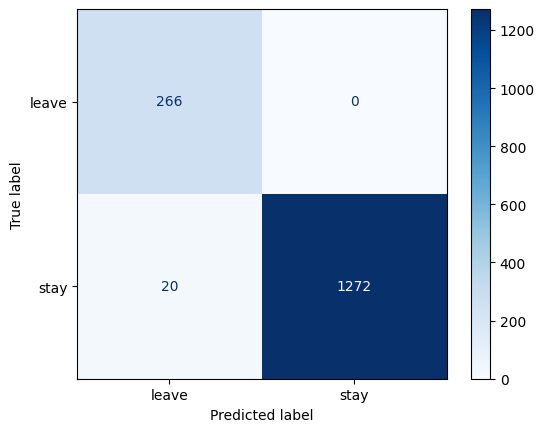

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert tensors to numpy
y_true = labels_test.numpy()
y_pred = predicted_classes.numpy()

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')


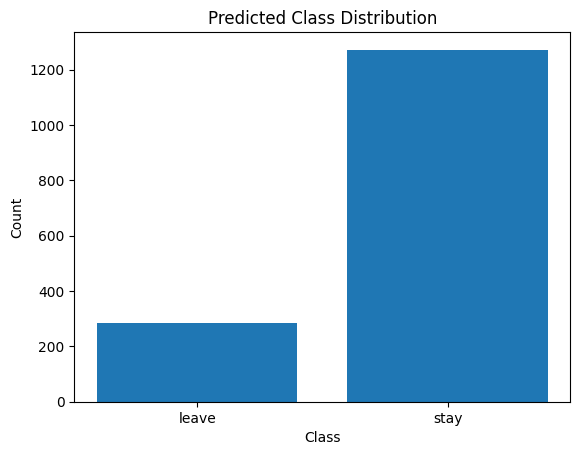

In [74]:
import matplotlib.pyplot as plt

classes = le.classes_  # ['leave', 'stay']
counts = torch.bincount(predicted_classes)

plt.bar(classes, counts.numpy())
plt.title('Predicted Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()
